In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx


from network_handler import Network_Handler
from network import Network
from person import Person
from disease_propagator import Disease_Propagator

In [8]:
# Parameters
population_size = 1000
average_degree = 5
random_edge_probability = 0.3

time_limit = 1000
unit_time = population_size # number of simulation steps that make up one time step

time_until_quarantine = {
    'mean': 4,
    'std_dev': 2
}
time_until_recovery = 10 # make distribution later
p = 0.1 # Factor for probability to become infected in public

In [9]:
population_IDs = range(population_size)

# Network
# Degrees ranging from 3 to 10
# Clustering coefficient: between 0.15 and 0.2 
# Average shortest path length around 6
# -> Typical for social networks [Networks: An Introduction by Newman, my google sheet]
network = Network(population_size,average_degree,random_edge_probability)

# Population dictionary
# {ID: Person}
population = network.get_population()

In [10]:
# Network handler
network_handler = Network_Handler(network)

# Randomly reduced network
randomly_reduced_network = network_handler.random_reduction()

# Reduced network with triadic strategy
triadic_network = network_handler.triadic_strategy()

print(len(list(network.edges)))
print(len(list(randomly_reduced_network.edges)))
print(len(list(triadic_network.edges))) 

2000
1322
1313


In [11]:
disease = Disease_Propagator(time_limit, time_until_quarantine['mean'], time_until_quarantine['std_dev'])
S_t_base, I_t_base = disease.simulate(network, time_until_recovery, p)
S_t_random, I_t_random = disease.simulate(randomly_reduced_network, time_until_recovery, p)
S_t_triadic, I_t_triadic = disease.simulate(triadic_network, time_until_recovery, p)


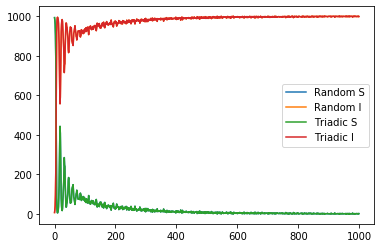

In [13]:
time_range = np.arange(0, time_limit, 1)
fig, ax = plt.subplots()
ax.plot(time_range, S_t, label="Base S")
ax.plot(time_range, I_t, label="Base I")
ax.plot(time_range, S_t_random, label="Random S")
ax.plot(time_range, I_t_random, label="Random I")
ax.plot(time_range, S_t_triadic, label="Triadic S")
ax.plot(time_range, I_t_triadic, label="Triadic I")
ax.legend()

In [10]:
# just some general testing
network1 = nx.Graph()
network1.add_nodes_from([1,2])
network1.add_edge(1,2)
network2 = network1.copy()
network2.remove_edge(1,2)
network1.edges()
ls = list(network1.edges)


TypeError: remove_edge() missing 1 required positional argument: 'v'